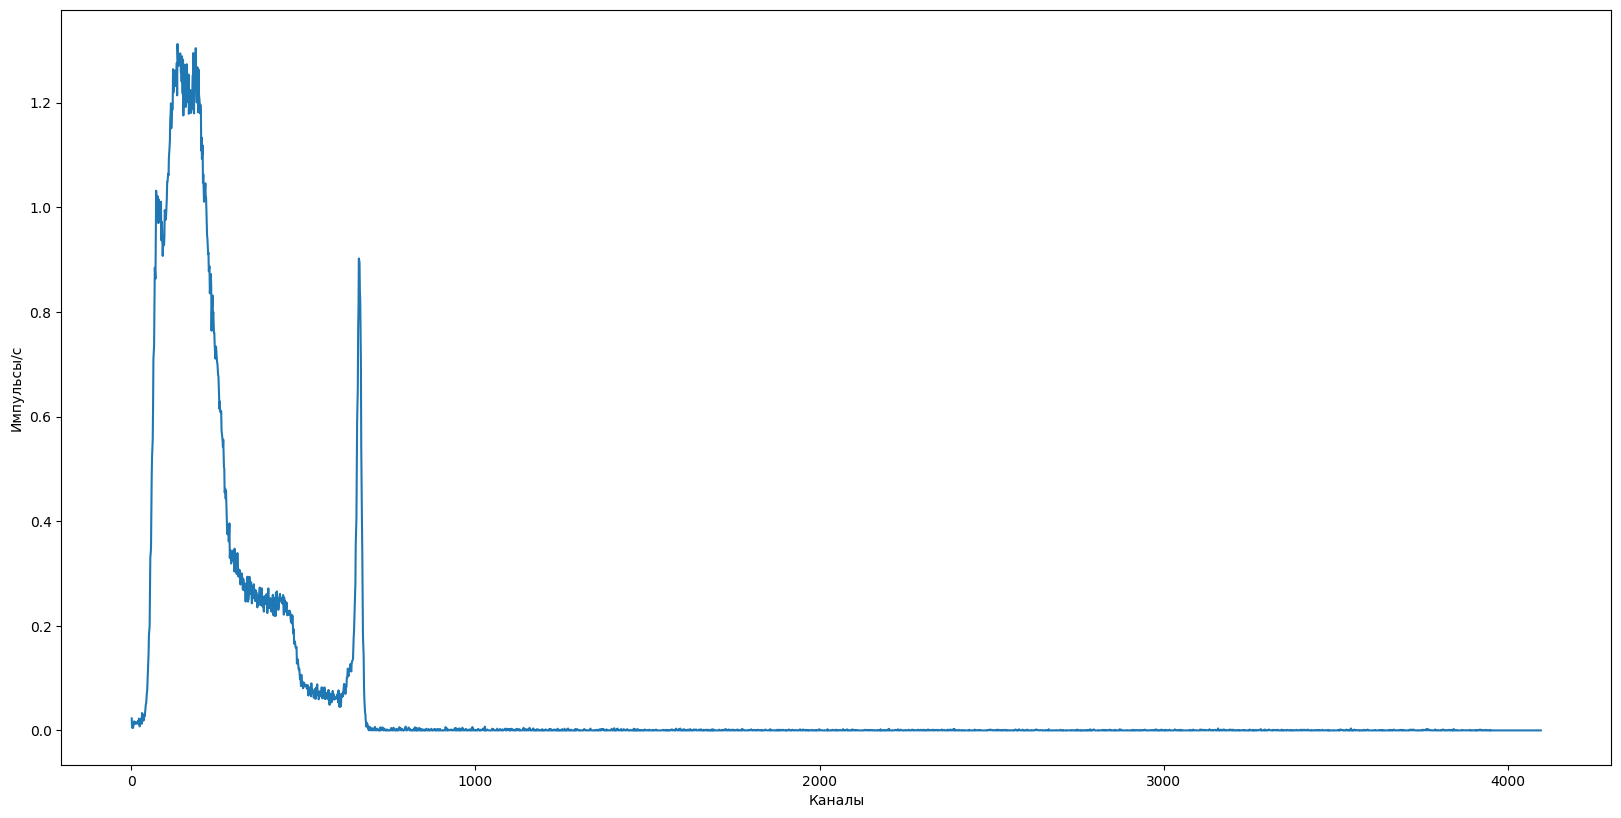

In [1]:
# чтение спектров и подготовка 

import os

directory = 'D:/1_Научная работа/Collimator_100_0_line' #
list_of_files = os.listdir(directory) #список файлов
bulls= [] # временный список
for i in list_of_files:
    with open(directory + '/'+ i, 'r') as f:
        tmp=f.readlines()
        bulls.append(tmp)

chanel=[] # список массивов каналов
for j in bulls:
    a = j[0].split(' ') # чтение живого времени
    t = a[3] 
    t=t.replace(',', '.')
    time=float(t[:len(t)-2])
    #print('Живое время = ',time, ' секунд')
    ch = []           # список каналов
    for i in range(2,4098):  # чтение импульсов в каналах
        a = j[i].split(' ')
        ch.append(a[2])
    ch=list(map(float, ch))    
    ch=list(map(lambda x: x/time,ch))
    chanel.append(ch)
# сейчас у меня есть список из 11 элементов, каждый из которых это массив импульсов по каналам.   
# а последний элемент(12ый), это массив импульсов для фона 

# вычитаем фон 

for i in range(11):
    for p in range(4096):
        chanel[i][p]=chanel[i][p]-chanel[11][p]
        if (chanel[i][p]<0):
            chanel[i][p]=0


import matplotlib.pyplot as plt
%matplotlib inline   

import numpy as np
            
fig=plt.figure(figsize=(20,10), dpi=100)
plt.plot(np.arange(1,4097,1), chanel[0])
plt.xlabel('Каналы')
plt.ylabel('Импульсы/c')
fig.savefig('before_filter', fmt='png')

# f_input=open('input.txt', 'w')

# for i in range(4096):
#       f_input.write(str("%.6f" % chanel[0][i]) + '\n')
    

In [2]:
# # метод скользящего среднего

# c=0
# while c<2:
#     for i in range(11):
#         for j in range(2,4094):
#             chanel[i][j]=1/5*(sum([chanel[i][j-2],chanel[i][j-1],chanel[i][j],chanel[i][j+1],chanel[i][j+2]]))
#     c=c+1

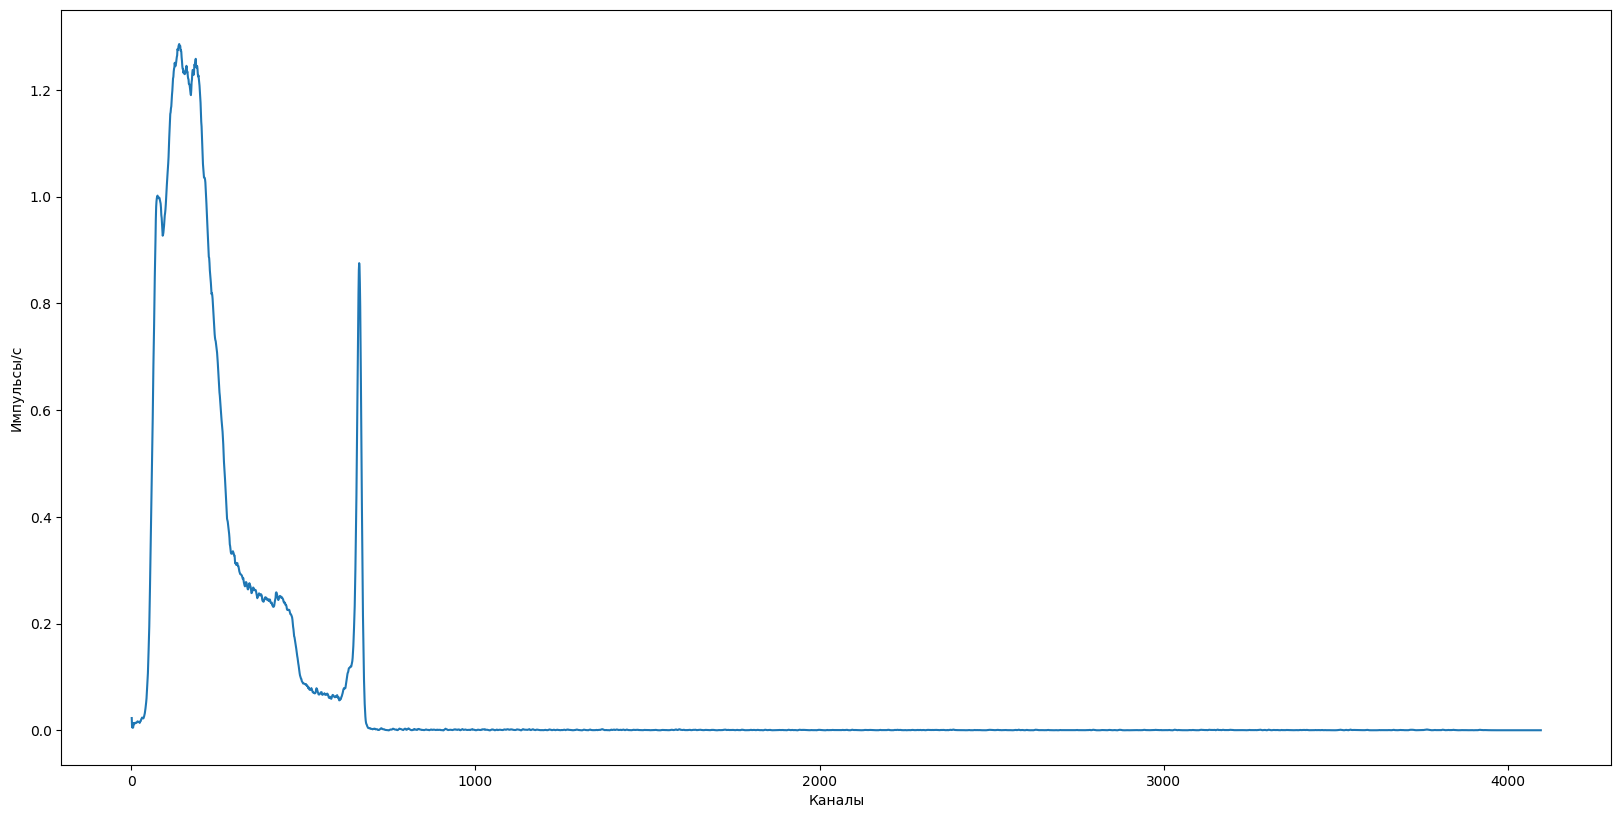

In [3]:
#параболический фильтр по 15-ти точкам 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

for i in range(11):
     
    for p in range (7,4089):
    
        Am = 1105
        sgla = (1/Am)*((-78)*chanel[i][p-7] - 13*chanel[i][p-6] + 42*chanel[i][p-5] + 87*chanel[i][p-4] + 122*chanel[i][p-3] + 147*chanel[i][p-2] + 162*chanel[i][p-1] + 167*chanel[i][p] + 162*chanel[i][p+1] + 147*chanel[i][p+2] + 122*chanel[i][p+3] + 87*chanel[i][p+4] - 78*chanel[i][p+7] - 13*chanel[i][p+6] + 42*chanel[i][p+5])
        chanel[i][p] = sgla
    
    
fig=plt.figure(figsize=(20,10), dpi=100)
plt.plot(np.arange(1,4097,1), chanel[0])
plt.xlabel('Каналы')
plt.ylabel('Импульсы/c')
fig.savefig('after_filter_15', fmt='png')

In [4]:
# import numpy as np

# import matplotlib.pyplot as plt
# %matplotlib inline  

# for i in range(11):
     
#     for p in range (6,4090):
    
#         Am = 143
#         sgla = (1/Am)*((-11)*chanel[i][p-6] + 9*chanel[i][p-4] + 16*chanel[i][p-3] + 21*chanel[i][p-2] + 24*chanel[i][p-1] + 26*chanel[i][p] + 24*chanel[i][p+1] + 21*chanel[i][p+2] + 16*chanel[i][p+3] + 9*chanel[i][p+4] - 11*chanel[i][p+6])
#         chanel[i][p] = sgla
    
    
# fig=plt.figure(figsize=(20,10), dpi=100)
# plt.plot(np.arange(1,4097,1), chanel[0])
# plt.xlabel('Каналы')
# plt.ylabel('Импульсы/c')
# fig.savefig('after_filter_13', fmt='png')

In [5]:
# поиск констант и подсчет интеграла

from scipy.optimize import minimize
from scipy import integrate
import numpy as np

h=1 #высота от детектора до источника
chanel_out=[]
mistake=[]
mistake_last=[]
x=np.arange(0,1.1,0.1) 

#bnds=((0, None),(0,None))

f_problems=open('problems.txt', 'w')
#f_out=open('koeff.txt', 'w')
#f_nevyazka=open('nevyazka.txt','w')

f_tmpout_alpha=open('tmp_alpha.txt', 'w')
f_tmpout_beta=open('tmp_beta.txt', 'w')
f_tmplast_alpha=open('tmplast_alpha.txt', 'w')
f_tmplast_beta=open('tmplast_beta.txt', 'w')
f_integr_in=open('integr_in.txt', 'w')
f_integr_out=open('integr_out.txt', 'w')

# ch_alpha=[]
# ch_beta=[]
# ch_alpha_last=[]
# ch_beta_last=[]

for p in range(4096):
    
    def f(x,alpha,beta):
         return alpha*h**(beta)/(h**2+x**2)**((beta+2)/2) 
        
    def delta(alpha, beta):
        d=0
        for i in range(11):
            d=d+(f(x[i],alpha,beta)-chanel[i][p])**2 
        return d

    res=minimize(lambda x: delta(*x), [1,1])
    a=res.x[0]
    b=res.x[1]
    
    mistake.append((res.fun)**0.5)
    
    #f_out.write(str(p) + '   alpha=' + str("%.4f" % a) + ' beta=' + str("%.4f" % b) + ',    ')
    #f_nevyazka.write(str(p+1) + '  '+ str("%.6f" % res.fun))
    
    f_tmpout_alpha.write(str("%.6f" % a) + '\n')
    f_tmpout_beta.write(str("%.6f" % b) + '\n')
    
    if b<0:
        f_problems.write(str(p+1) + ' beta= '+ str("%.5f" % b) + '\n')
        b=1
        
    # получил альфа и бета для интерполирующей функции на всем интервале

    def g(x):
        return 2*np.pi*a*x*h**b/(h**2+x**2)**((b+2)/2)
    
    carpet=integrate.quad(g,0,1)

    # проинтегрировал интерполирующую функцию на интервале (0,1)

    def f_last(x, alpha,beta):
        return alpha*h**(beta)/(h**2+x**2)**((beta+2)/2)

    def delta_last(alpha,beta):
        d=0
        for i in range(9,11):
            d=d+(f_last(x[i],alpha,beta)-chanel[i][p])**2 
        return d

    res_last=minimize(lambda x: delta_last(*x), [1,1])
    a=res_last.x[0]
    b=res_last.x[1]
    
    mistake_last.append((res_last.fun)**0.5)
    
    #f_out.write('на последнем интервале alpha='+ str("%.4f" % a) + ', beta= ' + str("%.4f" % b) + '\n')
    #f_nevyazka.write('  ' + str("%.6f" % res_last.fun) + '\n')
    
    #ch_alpha.append(a)
    #ch_beta.append(b)
    
    f_tmplast_alpha.write(str("%.6f" % a) + '\n')
    f_tmplast_beta.write(str("%.6f" % b) + '\n')
    
    if b<0:
        f_problems.write(str(p+1) + ' last ' + ' beta = ' + str("%.5f" % b) + '\n')
        b=1
       
    # получил альфа и бета для последнего интервала

    def g_last(x):
        return 2*np.pi*a*x*h**b/(h**2+x**2)**((b+2)/2)
    
    carpet_last=integrate.quad(g_last,1, np.inf)
         
    # проинтегрировал интерполирующую функцию с коэффициентами из последнего интервала по бесконечности
    
    chanel_out.append(carpet[0]+carpet_last[0])
    f_integr_in.write(str("%.6f" % carpet[0]) + '\n')
    f_integr_out.write(str("%.6f" % carpet_last[0]) + '\n')
    
    
f_integr=open('integr.txt', 'w')
f_integr.write('кэВ  ' + '  имп*м^2/с' + '\n')

f_mistake=open('mistake.txt', 'w')
f_mistake_last=open('mistake_last.txt', 'w')

for i in range(4096):
    f_integr.write(str("%.6f" % chanel_out[i]) + '\n')
    f_mistake.write(str("%.6f" % mistake[i]) + '\n')
    f_mistake_last.write(str("%.6f" % mistake_last[i]) + '\n')

    
#f_out.close()
f_tmplast_alpha.close()    
f_tmplast_beta.close()
f_integr.close()
f_tmpout_alpha.close()
f_tmpout_beta.close()
f_mistake.close()
f_mistake_last.close()
f_problems.close()
f_integr_in.close()
f_integr_out.close()
#f_nevyazka.close()

In [32]:
# # нахожу алфьа и бета для построения графиков зависимости альфа и бета от номера интервала
# # костыли жуткие

# ch_alpha_graph=[]
# ch_beta_graph=[]

# f_tmpout_alpha_graph=open('tmp_alpha_graph_460.txt', 'w')
# f_tmpout_beta_graph=open('tmp_beta_graph_460.txt', 'w')

# for j in range(10):    
        
#         def f_graph(x, alpha,beta):
#             return alpha*h**(beta)/(h**2+x**2)**((beta+1)/2)

#         def delta_graph(alpha,beta):
#             d=0
#             for i in range(j,j+1):
#                 d=d+(f_graph(x[j],alpha,beta)-chanel[j][460])**2 
#             return d

#         res_graph=minimize(lambda x: delta_graph(*x), [1,1])
#         a=res_graph.x[0]
#         b=res_graph.x[1]
#         ch_alpha_graph.append(a)
#         ch_beta_graph.append(b)
#         f_tmpout_alpha_graph.write(str("%.6f" % a) + '\n')
#         f_tmpout_beta_graph.write(str("%.6f" % b) + '\n')
    
#      #поправить то что дальше   
# #fig=plt.figure(figsize=(20,10), dpi=100)
# #plt.plot(np.arange(1,11,1), ch_alpha_graph)
# #plt.xlabel('Номер интервала')
# #plt.ylabel('Коэффициенты alpha')
# #fig.savefig('alpha_graph_510', fmt='png')
    
# #fig1=plt.figure(figsize=(20,10), dpi=100)
# #plt.plot(np.arange(1,11,1), ch_beta_graph)
# #plt.xlabel('Номер интервала')
# #plt.ylabel('Коэффициенты beta')
# #fig1.savefig('beta_graph_510', fmt='png')

# f_tmpout_alpha_graph.close()
# f_tmpout_beta_graph.close()

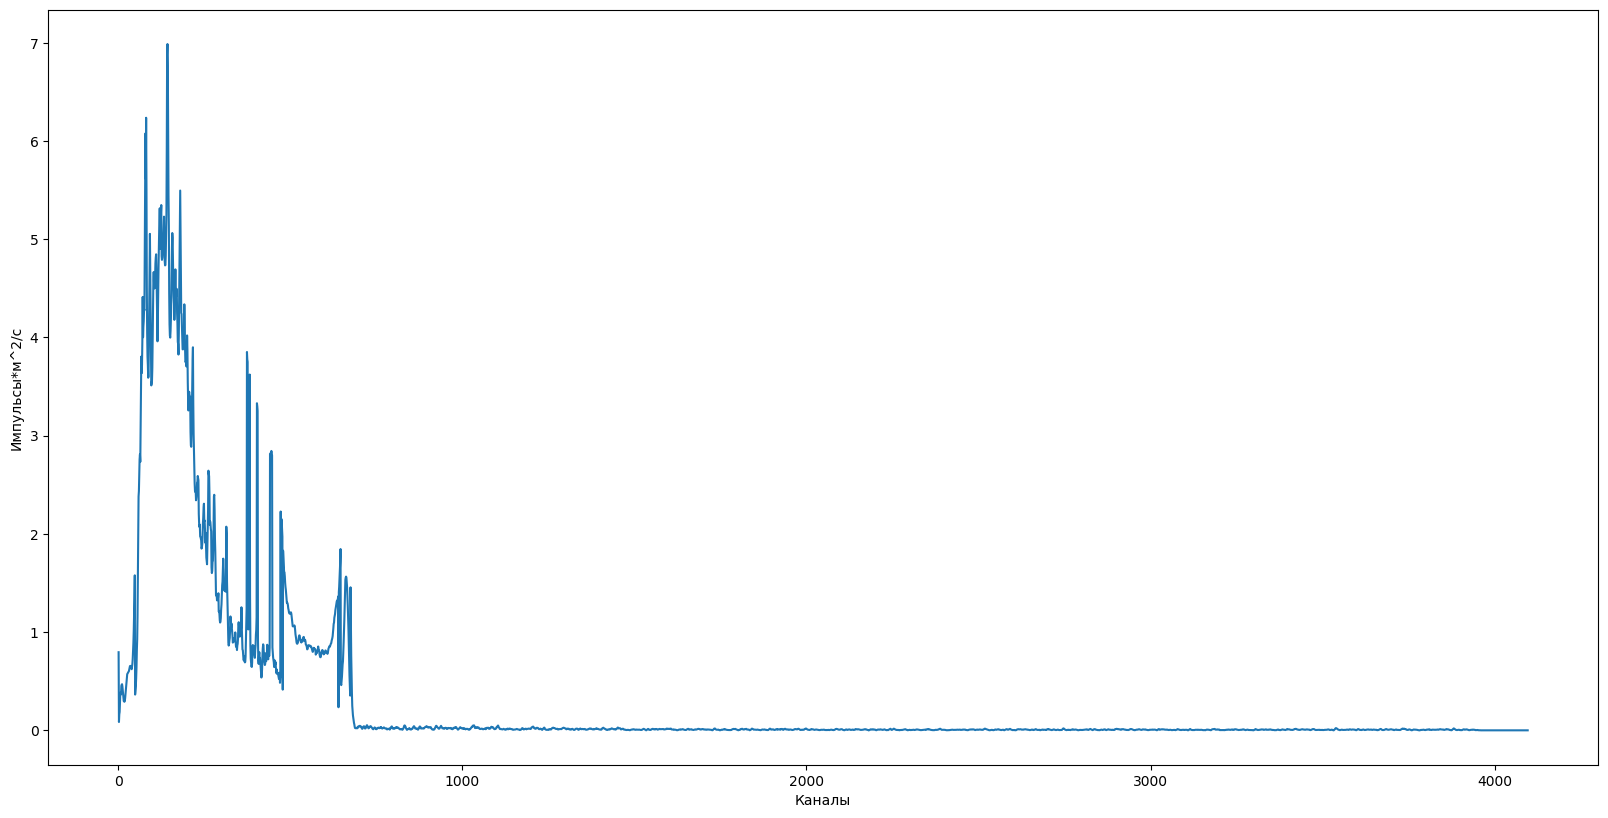

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline        

# выводит график в редакторе кода

fig=plt.figure(figsize=(20,10), dpi=100)
plt.plot(np.arange(1,4097,1), chanel_out)
plt.xlabel('Каналы')
plt.ylabel('Импульсы*м^2/с')
fig.savefig('integr_out', fmt='png')

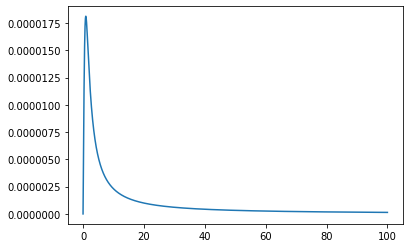

In [16]:
plt.plot(np.arange(0,100,0.01),g_last(np.arange(0,100,0.01)))

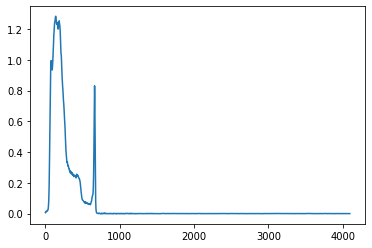

In [8]:
ch_tmp=[]
for j in range(4095):
    ch_tmp.append(chanel[0][j])

plt.plot(np.arange(1,4096,1), ch_tmp)




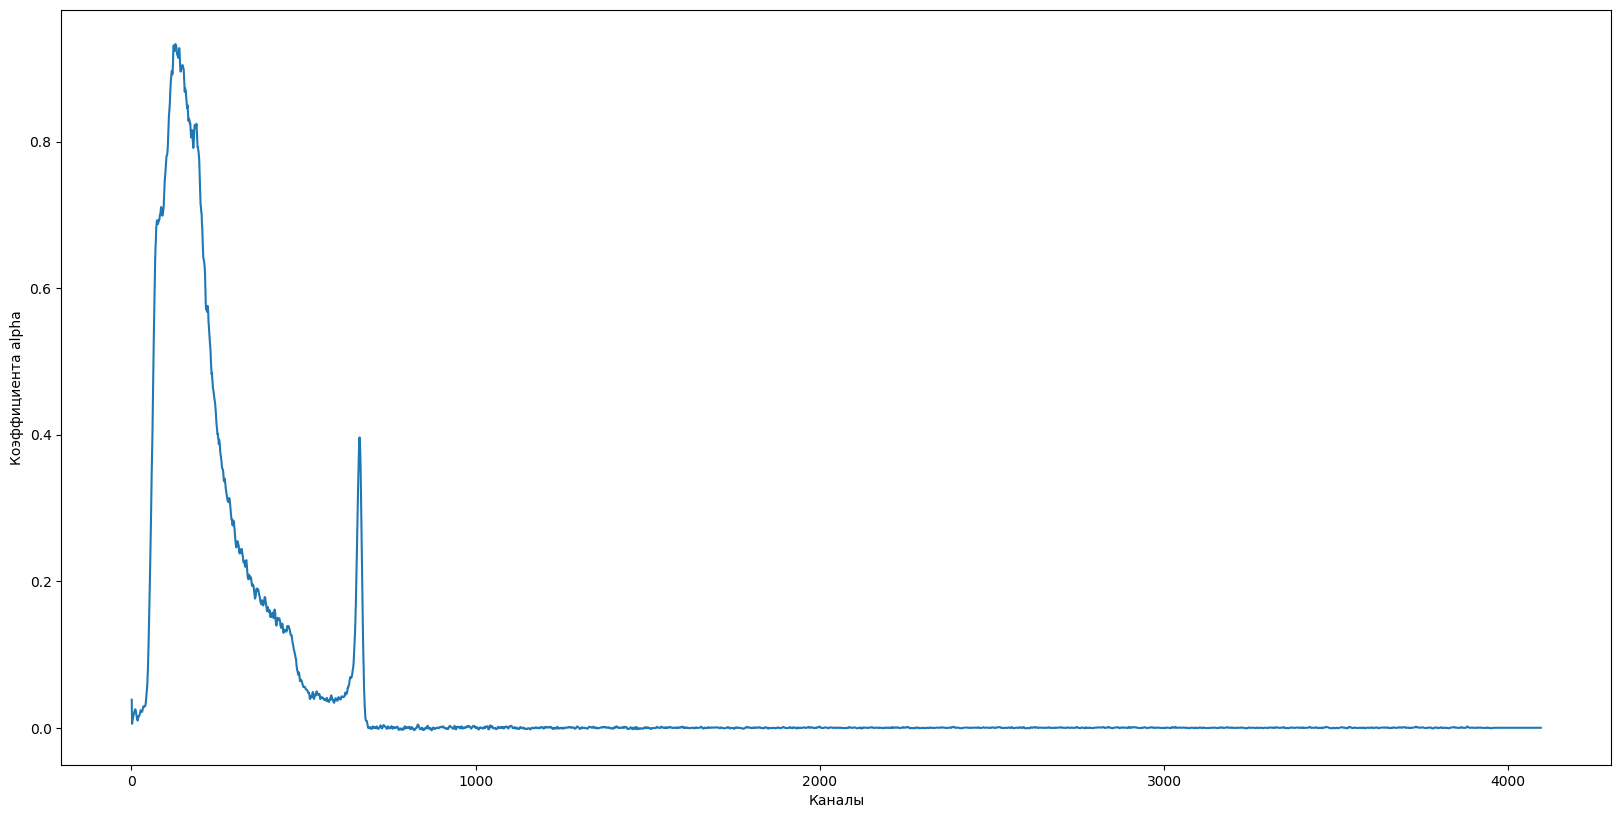

In [10]:
fig=plt.figure(figsize=(20,10), dpi=100)
plt.plot(np.arange(1,4096,1), ch_alpha)
plt.xlabel('Каналы')
plt.ylabel('Коэффициенты alpha')
fig.savefig('alpha', fmt='png')

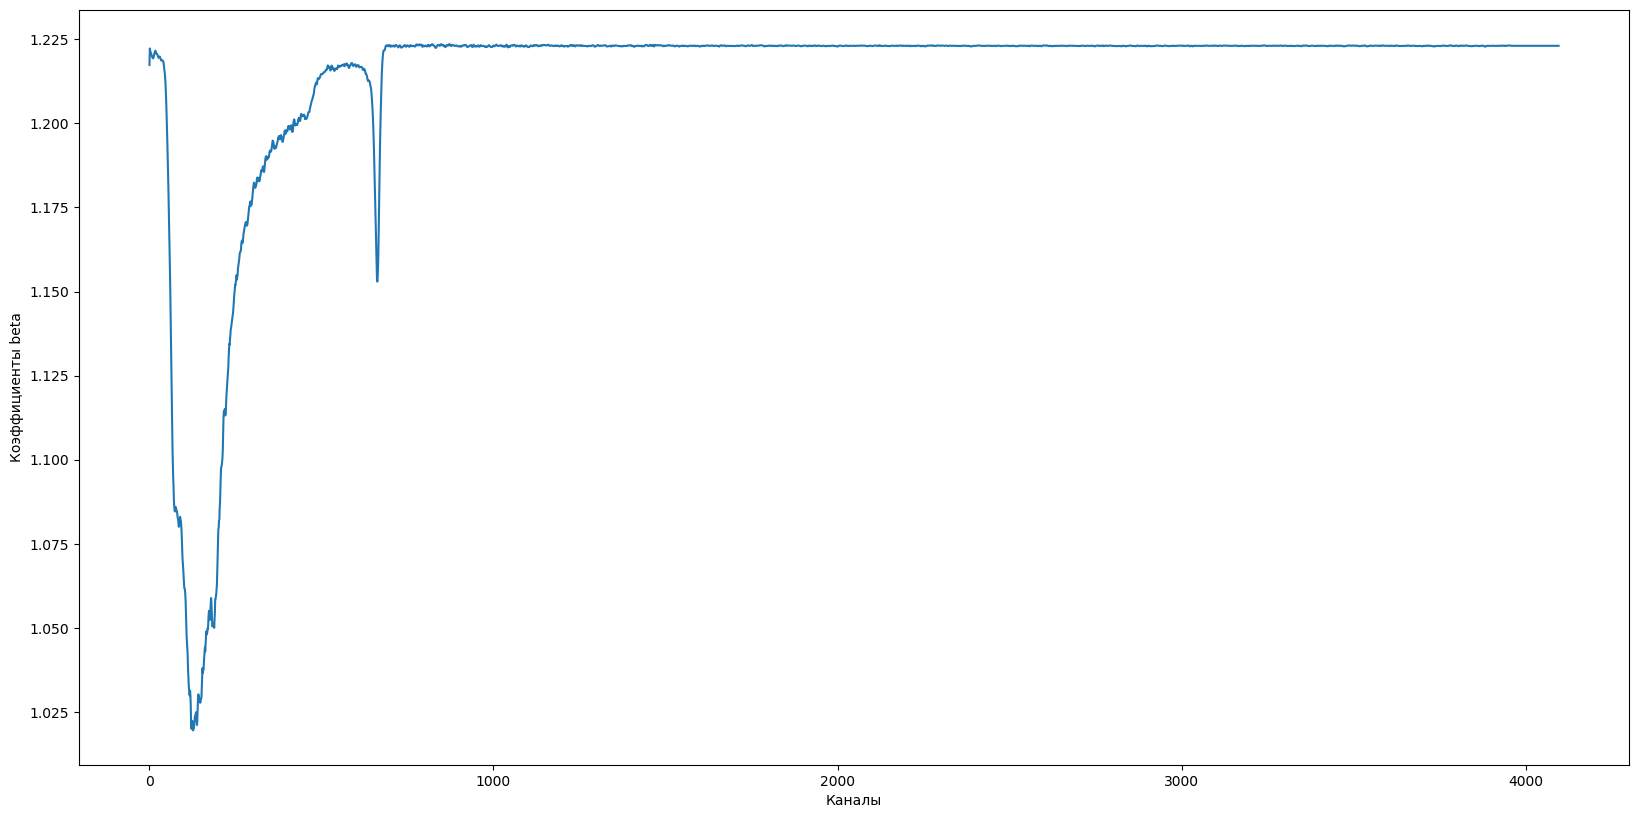

In [12]:
fig_1=plt.figure(figsize=(20,10), dpi=100)
plt.plot(np.arange(1,4096,1), ch_beta)
plt.xlabel('Каналы')
plt.ylabel('Коэффициенты beta')
fig_1.savefig('beta', fmt='png')